In [1]:
!rm -rf data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/
!rm -rf data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/
!rm -rf ./data/raw/dataset1/numpy_splited/
!rm -rf ./data/preprocessed/dataset1/train/
!rm -rf ./data/preprocessed/dataset1/test/
!rm -rf first_break_picking/example/data/raw/dataset1/numpy_splited/

In [2]:
! cp ../../mokrous_300_shots_IEEE_10-40Hz.sgy .
! cp ../../test_fbpicking_mokrous3d.txt .

In [22]:

! pip install segyio
! pip install matplotlib
! pip install ipympl
! jupyter labextension install @jupyter-widgets/jupyterlab-manager
! jupyter labextension install jupyter-matplotlib
! jupyter lab build
! pip install scipy
! pip install -e ..

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/usr/local/lib/python3.10/dist-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/usr/local/lib/python3.10/dist-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/usr/local/lib/python3.10/dist-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /tmp/jupyterlab-debug-7wju_uil.log
  warnings.warn(f"See the log file for details: {log_path!s}")
(

In [2]:
import sys
import os.path as osp
from pathlib import Path
import shutil
import os
import segyio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def AGC(data, window_length):
    """
    Функция для автоматической регулировки усиления (AGC).
    
    Аргументы:
    - data: двумерный массив (сейсмическая сейсмограмма).
    - window_length: размер окна для вычисления среднего значения энергии.

    Возвращает:
    - data_agc: данные после применения AGC.
    """
    data = data.T
    # Длины данных
    n_traces, n_samples = data.shape
    data_agc = np.zeros_like(data)

    # Цикл по трассам
    for trace_idx in range(n_traces):        
        trace = data[trace_idx]
        # Вычисляем энергию в скользящем окне
        envelope = np.convolve(np.abs(trace), np.ones(window_length), mode='same') / window_length
        # Избегаем деления на 0, добавляем небольшой сдвиг
        envelope[envelope == 0] = 1e-10
        # Усиление сигнала (нормализация)
        data_agc[trace_idx] = trace / envelope
    
    return data_agc.T

In [4]:
def read_and_split_segy(file_path: str, header1: str, header2: str, output_dir: str, split_nt: int) -> dict:
    """Читает сейсмограмму из файла SEGY, разбивает её по указанным заголовкам (header1, header2)
    и экспортирует подсейсмограммы в .npy файлы.

    Parameters
    ----------
    file_path : str
        Путь к файлу SEGY.
    header1 : str
        Первый заголовок, по которому будет происходить разбивка.
    header2 : str
        Второй заголовок, по которому будет происходить разбивка.
    output_dir : str
        Папка, куда будут сохранены .npy файлы.

    Returns
    -------
    dict
        Словарь сейсмограмм, разбитых по значениям указанных заголовков.
    """
    split_seismograms = {}

    with segyio.open(file_path, ignore_geometry=True) as segy_file:
        # Получаем количество следов
        num_traces = segy_file.tracecount
        # Создаем массив для хранения данных
        data = np.zeros((num_traces, len(segy_file.samples)))
        print(data.shape)
        # Чтение данных каждого следа
        for i in range(num_traces):
            data[i] = segy_file.trace[i]

        # # Визуализируем оригинальную сейсмограмму
        # plt.figure(figsize=(10, 6))
        # plt.imshow(data.T, aspect='auto', cmap='gray')
        # plt.title('Original Seismogram')
        # plt.xlabel('Trace Number')
        # plt.ylabel('Sample Number')
        # plt.colorbar(label='Amplitude')
        # plt.show()

        # Получаем значения атрибутов для двух заголовков
        try:
            field1 = getattr(segyio.TraceField, header1)
            field2 = getattr(segyio.TraceField, header2)
        except AttributeError as e:
            raise ValueError(f"Указанный заголовок '{e.args[0]}' отсутствует в TraceField.")

        attributes1 = segy_file.attributes(field1)[:]
        attributes2 = segy_file.attributes(field2)[:]

        # Группируем сейсмограммы по значениям двух заголовков
        for i in tqdm(range(num_traces)):
            header1_value = int(attributes1[i])  # Преобразуем значение первого заголовка в int
            header2_value = int(attributes2[i])  # Преобразуем значение второго заголовка в int
            key = (header1_value, header2_value)  # Используем кортеж в качестве ключа

            if key not in split_seismograms:
                split_seismograms[key] = []

            split_seismograms[key].append(data[i])  # Добавляем трассы без транспонирования

        for key, value in tqdm(split_seismograms.items()):
            split_seismograms[key] = np.array(value).T

    # Транспонируем уже собранные подсейсмограммы
    #transposed_seismograms = {key: value for key, value in split_seismograms.items() if value.shape[1] > split_nt}
    transposed_seismograms = {key: value for key, value in split_seismograms.items() if value.shape[1] == 180}
    
    #transposed_seismograms = {key: np.array(value).T for key, value in split_seismograms.items()}
    
    # Сохраняем в формате .npy
    os.makedirs(output_dir, exist_ok=True)

    for (header1_value, header2_value), value in tqdm(transposed_seismograms.items()):
        #file_name = os.path.join(output_dir, f"seismogram_{header1}_{header1_value}_{header2}_{header2_value}.npy")
        file_name = os.path.join(output_dir, f"{header1_value*1000+header2_value}.npy")
        #print(value.shape)
        # if value.shape[1] != 128:
        #     continue
        np.save(file_name, value)
        #print(f"Сохранено: {file_name}")

    return transposed_seismograms



def save_seismograms_with_headers(seismograms: dict, output_dir: str, header1: str, header2: str):
    """Сохраняет сейсмограммы в формате .npy с указанием значений двух заголовков в названии файла.

    Parameters
    ----------
    seismograms : dict
        Словарь сейсмограмм, где ключами являются кортежи (header1_value, header2_value),
        а значениями — NumPy массивы сейсмограмм.
    output_dir : str
        Путь к выходной директории для сохранения файлов.
    header1 : str
        Название первого заголовка.
    header2 : str
        Название второго заголовка.
    """
    os.makedirs(output_dir, exist_ok=True)  # Создаем директорию, если она не существует

    for (header1_value, header2_value), seismo_data in seismograms.items():
        # Формируем имя файла с учетом заголовков и их значений
        #file_name = f"seismogram_{header1}_{header1_value}_{header2}_{header2_value}.npy"
        file_name = f"{header1_value}{header2_value}.npy"
        file_path = os.path.join(output_dir, file_name)
        print(seismo_data.shape)
        # Сохраняем сейсмограмму в .npy
        np.save(file_path, seismo_data)
        print(f"Сохранено: {file_path}")





def data_normalize_and_limiting(data: np.ndarray) -> np.ndarray:
    """
    Trace based scale a shot

    Parameters
    ----------
    data : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    norma = np.max(np.abs(data), axis=0)
    norma[np.abs(norma) < 1e-9 * np.max(np.abs(norma))] = 1
    data = data / norma * 4
    data[data < -1] = -1
    data[data > 1] = 1
    return data


def trim_npy_files_normalize(input_directory, output_directory, num_samples):
    """
    Читает файлы .npy, обрезает их до заданного количества сэмплов и сохраняет с обновленным названием.
    
    :param input_directory: Папка с исходными .npy файлами
    :param output_directory: Папка, куда сохранять обрезанные файлы
    :param num_samples: Количество сэмплов, до которого необходимо обрезать
    """
    # Убедимся, что директория для сохранения существует
    os.makedirs(output_directory, exist_ok=True)

    # Проход по всем файлам в указанной директории
    for filename in os.listdir(input_directory):
        # Проверяем, является ли файл файлом .npy
        if filename.endswith(".npy"):
            file_path = os.path.join(input_directory, filename)  # Полный путь к файлу
            
            # Загрузка numpy массива
            data = np.load(file_path)
            print(f"Файл загружен. Исходный размер: {data.shape}")
            
            # Проверяем, что обрезка возможна
            if data.shape[0] < num_samples:
                print(f"Пропущен файл {filename}: недостаточно сэмплов ({data.shape[0]}).")
                continue
            
            # Обрезаем массив до заданного количества сэмплов
            trimmed_data = data[:num_samples, :]
            print(f"Размер обрезанного файла: {trimmed_data.shape}")
            
            # Генерируем новое имя файла, добавляя количество сэмплов в название
            base_name = os.path.splitext(filename)[0]
            #new_filename = f"{base_name}_trim_{num_samples}.npy"
            new_filename = f"{base_name}.npy"
            new_file_path = os.path.join(output_directory, new_filename)

            trimmed_data = data_normalize_and_limiting(trimmed_data)
            # Сохраняем обрезанный массив
            np.save(new_file_path, trimmed_data)
            print(f"Обработанный файл сохранён: {new_file_path}\n")

    print("Обрезка всех файлов завершена.")

In [5]:
from config import split_nt

In [6]:
file_path = r'mokrous_300_shots_IEEE_10-40Hz.sgy'
header1_to_split = 'EnergySourcePoint'  # Первый заголовок
header2_to_split = 'GroupStaticCorrection'  # Второй заголовок
output_directory = r'data/raw/dataset1/numpy_splited'  # Папка для сохранения .npy файлов
seismograms = read_and_split_segy(file_path, header1_to_split, header2_to_split, output_directory, split_nt)

(1285440, 1000)


100%|██████████| 7007/7007 [00:08<00:00, 807.73it/s] 


In [7]:
1

1

In [8]:
len(seismograms)

7007

In [9]:
output_diarectory = r'./data/raw/dataset1/numpy_splited'  # Папка для сохранения файлов
header1_to_use = 'NPS'
header2_to_use = 'RLN'

# Сохранение данных:
save_seismograms_with_headers(seismograms, output_directory, header1_to_use, header2_to_use)

(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766009.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766015.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766021.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766027.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766033.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766039.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766045.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766051.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766057.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766063.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766069.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766075.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766081.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766

In [10]:
len(os.listdir("./data/raw/dataset1/numpy_splited"))

14014

In [11]:
! ls ./data/raw/dataset1/numpy_splited | grep 24996059

249960595991.npy
249960595997.npy
249960596003.npy
249960596009.npy
249960596015.npy
249960596021.npy
249960596027.npy
249960596033.npy
249960596039.npy
249960596045.npy
249960596051.npy
249960596057.npy
249960596063.npy
249960596069.npy
249960596075.npy
249960596081.npy
249960596087.npy
249960596093.npy
249960596099.npy
249960596105.npy
249960596111.npy
249960596117.npy
249960596123.npy
249960596129.npy


In [12]:
# Директория с исходными .npy файлами
input_directory = r"./data/raw/dataset1/numpy_splited/"

# Директория для сохранения обрезанных файлов
output_directory = r"./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed"

# Задаём количество сэмплов для обрезки
num_samples = 750  # задайте нужное количество сэмплов

# Запускаем функцию
trim_npy_files_normalize(input_directory, output_directory, num_samples)

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24936082009.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24936082015.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24936082021.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24936082027.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24936082033.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/

In [13]:
! ls ./data/raw/dataset1

numpy_splited  test  train  train_ovch_by_rln_4ms_trimmed


In [14]:
len(os.listdir("./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/"))

14014

In [15]:
import pandas as pd
file_path = "test_fbpicking_mokrous3d.txt"

with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

with open(file_path, "w", encoding="utf-8") as file:
    file.writelines(line for line in lines if not line.lstrip().startswith("#"))

df = pd.read_csv(file_path, sep='\t', header = None)
df.columns = [x.strip() for x in "itrace  |   NSP |   NRP |   SLN |   RLN |   NTR |   FB_TIME".split("|")]



rln_list = sorted(df.RLN.value_counts().index.tolist())
nps_list = df.NSP.value_counts().index.tolist()
for nps in tqdm(nps_list):
    for rln in rln_list:
        fb_time = df[(df.NSP == nps) & (df.RLN == rln)].set_index('itrace').FB_TIME
        if fb_time.shape[0]:
            npy_path = f'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/{nps}{int(rln)}.npy'
            txt_path = f'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/{nps}{int(rln)}.txt'
            # Если файл .npy отсутствует, создаём .txt
            if os.path.exists(npy_path):
                fb_time.rename('Time').to_csv(txt_path, index=False)

            

100%|██████████| 301/301 [02:44<00:00,  1.83it/s]


In [16]:
len(os.listdir("./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/"))

21021

import os
import re
def keep_only_10_pairs(folder_path):
    """
    Функция находит все файлы вида XXXX.npy и XXXX.txt в папке folder_path,
    где XXXX – это некая числовая часть. Скрипт сохраняет только первые
    10 уникальных чисел (по возрастанию), а остальные файлы удаляет.
    """
    # Получаем список всех файлов в папке
    all_files = os.listdir(folder_path)
    
    # Словарь для группировки:
    # Ключ   -> число (int)
    # Значение -> список имён файлов с этим числом
    base_dict = {}
    
    # Регулярное выражение, чтобы извлечь число и расширение
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    
    # 1. Проходим по всем файлам в папке
    for filename in all_files:
        match = pattern.match(filename)
        if match:
            # match.group(1) – это сама числовая основа в виде строки
            # match.group(2) – расширение (npy или txt)
            base_num_str = match.group(1)
            base_num = int(base_num_str)
            
            # Сохраняем файл в словарь по ключу base_num
            if base_num not in base_dict:
                base_dict[base_num] = []
            base_dict[base_num].append(filename)
    
    # 2. Сортируем ключи (числа) по возрастанию
    sorted_numbers = sorted(base_dict.keys())
    
    # 3. Берём первые 10 чисел, которые хотим оставить
    numbers_to_keep = sorted_numbers[:30]
    
    # 4. Все остальные числа идут "за пределами" первых 10
    numbers_to_delete = sorted_numbers[30:]
    
    # 5. Удаляем файлы для чисел, которые не вошли в первые 10
    for base_num in numbers_to_delete:
        file_list = base_dict[base_num]
        for file_to_remove in file_list:
            full_path = os.path.join(folder_path, file_to_remove)
            print(f"Удаляю файл: {full_path}")
            os.remove(full_path)

keep_only_10_pairs("data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/")

In [17]:
import re
import os
def move_pairs_by_percentage(source_folder, destination_folder, percentage=0.2):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    files = os.listdir(source_folder)
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    groups = {}
    
    for f in files:
        match = pattern.match(f)
        if match:
            num = int(match.group(1))
            if num not in groups:
                groups[num] = []
            groups[num].append(f)
    
    sorted_nums = sorted(groups.keys())
    total_pairs = len(sorted_nums)
    pairs_to_move = int(total_pairs * percentage)
    
    for num in sorted_nums[:pairs_to_move]:
        for fname in groups[num]:
            shutil.move(os.path.join(source_folder, fname),
                        os.path.join(destination_folder, fname))
    
    print(f"Перемещено {pairs_to_move} из {total_pairs} пар.")

move_pairs_by_percentage("data/raw/dataset1/train_ovch_by_rln_4ms_trimmed",
                         "data/raw/dataset1/test_ovch_by_rln_4ms_trimmed", percentage=0.9)


Перемещено 12612 из 14014 пар.


In [18]:
import os
import re
import os
import re

def remove_unpaired_files(folder_path, dry_run=True):
    """
    Finds and removes files that have a .npy version but no corresponding .txt version,
    and vice versa.
    
    Args:
        folder_path: Path to the folder containing the files to check
        dry_run: If True, only reports what would be deleted without actual deletion.
                 Set to False to perform actual deletion.
        
    Returns:
        A tuple containing:
        - Count of files with .npy but no .txt that were deleted
        - List of file numbers with .npy but no .txt that were deleted
        - Count of files with .txt but no .npy that were deleted
        - List of file numbers with .txt but no .npy that were deleted
    """
    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Папка {folder_path} не существует.")
        return 0, [], 0, []
    
    # Get all files in the folder
    files = os.listdir(folder_path)
    
    # Create pattern to match file names with number and extension
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    
    # Dictionaries to track which numbers have which file types
    npy_files = {}
    txt_files = {}
    
    # Sort files into appropriate dictionaries
    for file in files:
        match = pattern.match(file)
        if match:
            num = int(match.group(1))
            ext = match.group(2)
            
            if ext == 'npy':
                npy_files[num] = file
            elif ext == 'txt':
                txt_files[num] = file
    
    # Find files with .npy but no .txt
    npy_only = [num for num in npy_files if num not in txt_files]
    npy_only_count = len(npy_only)
    
    # Find files with .txt but no .npy
    txt_only = [num for num in txt_files if num not in npy_files]
    txt_only_count = len(txt_only)
    
    # Process the unpaired files
    deleted_npy = []
    deleted_txt = []
    
    # Print and delete .npy files without corresponding .txt
    #print(f"Файлы с .npy но без .txt ({npy_only_count}):")
    for num in sorted(npy_only):
        file_path = os.path.join(folder_path, npy_files[num])
        #print(f"  {npy_files[num]}")
        
        if not dry_run:
            try:
                os.remove(file_path)
                deleted_npy.append(npy_files[num])
                #print(f"    Удален: {npy_files[num]}")
            except Exception as e:
                print(f"    Ошибка при удалении {npy_files[num]}: {e}")
    
    # Print and delete .txt files without corresponding .npy
    #print(f"\nФайлы с .txt но без .npy ({txt_only_count}):")
    for num in sorted(txt_only):
        file_path = os.path.join(folder_path, txt_files[num])
        #print(f"  {txt_files[num]}")
        
        if not dry_run:
            try:
                os.remove(file_path)
                deleted_txt.append(txt_files[num])
                #print(f"    Удален: {txt_files[num]}")
            except Exception as e:
                print(f"    Ошибка при удалении {txt_files[num]}: {e}")
    
    # Summary of actions
    if not dry_run:
        print(f"\nВсего удалено:")
        print(f"  {len(deleted_npy)} файлов .npy без соответствующих .txt")
        print(f"  {len(deleted_txt)} файлов .txt без соответствующих .npy")
    else:
        print("\nЭто был режим тестирования (dry run). Файлы не были удалены.")
        print("Для удаления файлов вызовите функцию с параметром dry_run=False")
    
    return len(deleted_npy), deleted_npy, len(deleted_txt), deleted_txt

# Example usage
# rem1ove_unpaired_files('/path/to/your/folder', dry_run=True)  # Just report
# remove_unpaired_files('/path/to/your/folder', dry_run=False)  # Actually delete
# Example usage
_ = remove_unpaired_files('data/raw/dataset1/train_ovch_by_rln_4ms_trimmed', dry_run=False)
_ = remove_unpaired_files("data/raw/dataset1/test_ovch_by_rln_4ms_trimmed", dry_run=False)



Всего удалено:
  0 файлов .npy без соответствующих .txt
  0 файлов .txt без соответствующих .npy

Всего удалено:
  7007 файлов .npy без соответствующих .txt
  0 файлов .txt без соответствующих .npy


In [56]:
! ls data/raw/dataset1/train_ovch_by_rln_4ms_trimmed

249960456039.npy  249960645997.txt  249960786099.npy  249961046063.txt
249960456039.txt  249960646003.npy  249960786099.txt  249961046069.npy
249960456045.npy  249960646003.txt  249960786105.npy  249961046069.txt
249960456045.txt  249960646009.npy  249960786105.txt  249961046075.npy
249960456051.npy  249960646009.txt  249960786111.npy  249961046075.txt
249960456051.txt  249960646015.npy  249960786111.txt  249961046081.npy
249960456057.npy  249960646015.txt  249960786117.npy  249961046081.txt
249960456057.txt  249960646021.npy  249960786117.txt  249961046087.npy
249960456063.npy  249960646021.txt  249960786123.npy  249961046087.txt
249960456063.txt  249960646027.npy  249960786123.txt  249961046093.npy
249960456069.npy  249960646027.txt  249960786129.npy  249961046093.txt
249960456069.txt  249960646033.npy  249960786129.txt  249961046099.npy
249960456075.npy  249960646033.txt  249960786135.npy  249961046099.txt
249960456075.txt  249960646039.npy  249960786135.txt  249961046105.npy
249960

In [19]:
! rm -rf ./data/preprocessed/dataset1/train/

In [20]:
#%% ========== Loading required packages 
import sys
import os.path as osp
from pathlib import Path
import shutil


from first_break_picking.data import save_shots_fb
from first_break_picking import predict



from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )
#%% ============ Define paths ===============
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/train_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/train"

# Path(path_to_save).mkdir(exist_ok=True, parents=True)
Path(preprocessed_path).mkdir(exist_ok=True, parents=True)
#%% =================== Prepare data =============
data_info = save_shots_fb(
        dataset_dir=raw_data_path,
        dir_to_save=preprocessed_path,
        split_nt= split_nt,
        overlap = overlap,
        time_window=[0, n_time_sampels],
        fbt_file_header=1,
        fbt_time_column=0,
        scale=True,
        grayscale=True,
        dt=dt,
        shot_ext=".npy",
        fb_ext=".txt"
        )
    
# %% ======== Show results ===========
checkpoint_path = project_path + f"/checkpoints/chp_fb_{num_epcohs}.tar"
print(f"checkpoint is loaded: {checkpoint_path}")



/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)
/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)
/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)
/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)


checkpoint is loaded: ./checkpoints/chp_fb_8.tar


/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)
/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)
/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)
/workspace/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in divide
  data = 255 * (nom/ denom + 0.5)


In [21]:
raw_data_path

'./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/'

In [22]:
!rm -rf ./data//preprocessed/dataset1/train/.ipynb_checkpoints

In [23]:
%matplotlib widget

In [24]:
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/train_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/train"

In [25]:
#%% ========== Loading required packages 
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from time import time
from pathlib import Path
import shutil
from matplotlib.ticker import MaxNLocator
# import sys
# sys.path.append(osp.abspath(osp.join(__file__, "../../")))
from first_break_picking import train
from first_break_picking.tools import seed_everything
from first_break_picking.data import save_shots_fb

from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     batch_size,
                     val_percentage,
                     num_epcohs,
                     step_size_milestone
                     )

/workspace/first_break_picking/first_break_picking/train_eval/parameter_tools.py:287: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/venv/main/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/workspace/first_break_picking/first_break_picking/train_eval/train.py:248: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  5%|▌         | 64/1178 [00:12<03:42,  5.01it/s, loss=0.201]


KeyboardInterrupt: 

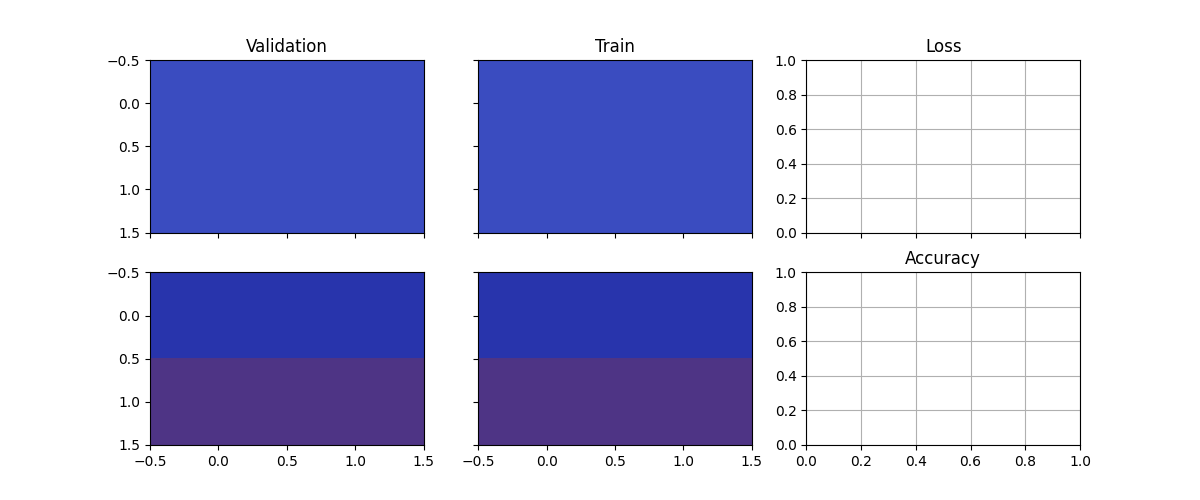

In [26]:
#%% =================== Training =================
tic = time()
train(preprocessed_path, 
    upsampled_size_row=n_time_sampels,
    upsampled_size_col=upsampled_size,
    batch_size=batch_size, 
    val_percentage=val_percentage,
    epochs=num_epcohs, 
    learning_rate=1e-4, 
    type_of_problem="fb",
    device="cuda",
    checkpoint_path=None,
    path_to_save= project_path,
    save_frequency=num_epcohs,
    show=True,
    step_size_milestone=step_size_milestone
    )
toc = time()
print(f"It took {toc - tic} s for {num_epcohs} epochs")

# %% ============= plot metrics =================
metrics_path = f"{project_path}/checkpoints/metrics_fb.csv"
metrics = pd.read_csv(metrics_path)
    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
ax.plot(metrics.train_loss, label="Training set", 
    color="k")
ax.plot(metrics.valid_loss, linestyle="--",
     color="k", label="Validation set", linewidth=3
     )
ax.grid()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()

ax = fig.add_subplot(122)
ax.plot(metrics.pixel_accuracy, label="Pixel",
    color="k")
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

#shutil.rmtree(f"{data_base_train}/preprocessed")
plt.show()


In [7]:
import os
import shutil

if os.path.exists("./data/picked_fb_test_data"):
    shutil.rmtree("./data/picked_fb_test_data")


#%% ========== Loading required packages 
import sys
import os.path as osp
from pathlib import Path



from first_break_picking.data import save_shots_fb
from first_break_picking import predict


from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )
#%% ============ Define paths ===============
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/test_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/test"

# Path(path_to_save).mkdir(exist_ok=True, parents=True)
Path(preprocessed_path).mkdir(exist_ok=True, parents=True)
#%% =================== Prepare data =============
data_info = save_shots_fb(
        dataset_dir=raw_data_path,
        dir_to_save=preprocessed_path,
        split_nt= split_nt,
        overlap = overlap,
        time_window=[0, n_time_sampels],
        fbt_file_header=1,
        fbt_time_column=0,
        scale=True,
        grayscale=True,
        dt=dt,
        shot_ext=".npy",
        fb_ext=None
        )
    
# %% ======== Show results ===========
checkpoint_path = project_path + f"/checkpoints/chp_fb_{num_epcohs}.tar"
print(f"checkpoint is loaded: {checkpoint_path}")

predict(base_dir=preprocessed_path, 
        path_to_save=data_base_train,
        checkpoint_path=checkpoint_path,
        split_nt=split_nt, 
        overlap=overlap, 
        upsampled_size_row=n_time_sampels, 
        upsampled_size_col=upsampled_size,
        dt=dt, 
        smoothing_threshold=50,
        data_info=data_info, 
        model_name="unet_resnet",
        validation=False,
        save_list=None,
        out_channels=2,
        save_segmentation=False
        )

#shutil.rmtree(f"{data_base_train}/preprocessed")


KeyError: 0

In [22]:
1

1

In [20]:
from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )

### Тулы для работы с DataLoader и преобразований данных

In [21]:
import torch
import torchvision.transforms as t
from typing import Any, List, Optional, Union, Tuple

from torch.utils.data import Dataset
import torchvision.transforms as t
from typing import Tuple, List
from torch.utils.data import DataLoader
import numpy as np

# тут больше про DataLoader
class FirstBreakOneShot(Dataset):
    def __init__(self, data_dir: str, 
                 shot_name_2_num_subshots: dict) -> None:
        super().__init__()
        self.path = data_dir
        files = os.listdir(self.path)
        self.files = files
        self.n_data = len(shot_name_2_num_subshots)
        
        self.shot_name_2_num_subshots = shot_name_2_num_subshots
        self.files.sort()
        self.shots_id = list(shot_name_2_num_subshots.keys())
        self.set_transforms() 
        self.count = 0

    def __len__(self):
        return self.n_data 

    def __getitem__(self, index):
        print("before ind", index)
        #index = self.count
        print("after ind", index)
        main_shot_name = self.shots_id[index]
        
        bs = shot_name_2_num_subshots[main_shot_name]
        if bs>1: 
            files = [f"{main_shot_name}_{i}.npy" for i in range(bs)]
        else:  # if we don't split data
            files = [f"{main_shot_name}.npy"]
        print(files)
        #shot = load_one_shot(self.path, files)
        shot = [np.load(self.path + f"/{file}", allow_pickle=True) for file in files]
        
        # shot = load_one_shot(self.path, self.files[index*self.bs:(index+1)*self.bs])
        bs = len(shot)
        nt, n_trace = shot[0].shape
        batch = torch.zeros((bs, 1, nt, n_trace))
        for i in range(bs):
            batch[i, 0, ...] = self._transforms(shot[i])  # torch.from_numpy(shot[i])
        
        self.count += 1
        return batch, main_shot_name

    def set_transforms(self) -> None:
        self._transforms = general_transform()



def general_transform():
    transforms = t.Compose([ 
                t.ToTensor(),
                t.Normalize(
                    mean = 0.5,
                    std= 0.5
                )])
    return transforms



# тут про прообразования сам инференс

class Upsample:
    def __init__(self, size: Tuple[int, int]):
        
        self._upsampler = torch.nn.Upsample(size=size)
        self.size = self._upsampler.size
        
    def __call__(self, data, label):
        
        return (self._upsampler(data), 
                (self._upsampler(label)).long())


def predict_model(model,
            data: torch.Tensor, 
            binary: bool):
    """
    Predict the segments

    Parameters
    ----------
    model : UNet
        _description_
    data : torch.Tensor
        _description_

    Returns
    -------
    _type_
        segmented result
    """
    predicted_logit = model(data)

    if binary:
        prob = torch.sigmoid(predicted_logit.squeeze(1))
        # predicted = predicted[predicted>0.5]
        predicted = torch.argmax(torch.diff(prob, dim=1), dim=1)

    else:
        prob = torch.softmax(predicted_logit, dim=1)
        predicted = torch.argmax(prob, dim=1)
    return predicted, prob







In [22]:
# создаем объекты классов указанных выше
_transforms = general_transform()

upsampler = Upsample(
    size=(n_time_sampels, upsampled_size)
    )

### Загрузка модели

In [23]:
import segmentation_models_pytorch as smp


device = 'cpu'

features = [16, 32, 64, 128]
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,              
    classes=2,                    
    decoder_channels =features[::-1],
    encoder_depth=len(features)
)

state = torch.load('./checkpoints/chp_fb_15.tar', map_location=torch.device(device))
model.load_state_dict(state) 




/var/folders/qx/8lfz_yns1qv3pz4b786vy6dc0000gn/T/ipykernel_48628/520179121.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('./checkpoints/chp_fb_15.t

<All keys matched successfully>

### Инференс при помощи DataLoader

In [9]:
from tqdm import tqdm
import torch

preprocessed_path = './data//preprocessed/dataset1/test'
shot_name_2_num_subshots = data_info.set_index("shot_id").number_of_subshots.to_dict()

test_dataset = FirstBreakOneShot(
        data_dir='./data//preprocessed/dataset1/test',
        shot_name_2_num_subshots=shot_name_2_num_subshots)

loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loop = tqdm(loader)
with torch.no_grad():
    for shot_number, (batch, fbt_file_name) in enumerate(loop):
        fbt_file_name = fbt_file_name[0]
        print("predict::batch",batch.shape)
        #batch = batch.squeeze(0).to(device=device)
        print(batch.shape)
        batch, _ = upsampler(batch.squeeze(0), batch.squeeze(0))
        print(batch.shape)
        predicted, prob = predict_model( # Check why I use prob here but not for validation
            model=model, data=batch,
            binary=False)

        

  0%|                                                                                                                                                           | 0/47 [00:00<?, ?it/s]

before ind 0
after ind 0
['10753413_0.npy', '10753413_1.npy', '10753413_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  2%|███▏                                                                                                                                               | 1/47 [00:00<00:25,  1.83it/s]

before ind 1
after ind 1
['10753414_0.npy', '10753414_1.npy', '10753414_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  4%|██████▎                                                                                                                                            | 2/47 [00:01<00:23,  1.94it/s]

before ind 2
after ind 2
['10753415_0.npy', '10753415_1.npy', '10753415_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  6%|█████████▍                                                                                                                                         | 3/47 [00:01<00:20,  2.10it/s]

before ind 3
after ind 3
['10753416_0.npy', '10753416_1.npy', '10753416_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  9%|████████████▌                                                                                                                                      | 4/47 [00:02<00:22,  1.95it/s]


before ind 4
after ind 4
['10753417_0.npy', '10753417_1.npy', '10753417_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


KeyboardInterrupt: 

### Инференс с нуля (тех данных которые мы сами нагенерили и которые принимает train)

In [24]:
from typing import Any, List, Optional, Union, Tuple

def data_normalize_and_limiting(data: np.ndarray) -> np.ndarray:
    """
    Trace based scale a shot

    Parameters
    ----------
    data : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    norma = np.max(np.abs(data), axis=0)
    norma[np.abs(norma) < 1e-9 * np.max(np.abs(norma))] = 1
    data = data / norma * 2
    data[data < -1] = -1
    data[data > 1] = 1
    return data

def shot_to_gray_scale(data: np.ndarray) -> np.ndarray:
    """
    Transform a shot to grayscale image in [0, 255]

    Parameters
    ----------
    data : np.ndarray
        One seismic shot

    Returns
    -------
    np.ndarray
        The shot in gray scale
    """
    nom = data - np.mean(data, axis=0)
    denom = 2 * (np.max(data, axis=0) - np.min(data, axis=0))
    if denom.all() < 0.000001:
        print("denom", denom)
    data = 255 * (nom/ denom + 0.5)
    data[np.isnan(data)] = 0
    return data

def split_seismogram(shot: np.ndarray, split_nt: int, overlap: float) -> List[np.ndarray]:
    """
    Split a seismogram into overlapping segments of specified width.
    
    Parameters
    ----------
    shot : np.ndarray
        Original seismogram data with shape (time_samples, n_traces)
    split_nt : int
        Width of each segment (number of traces)
    overlap : float
        Overlap fraction between segments (0-1)
    
    Returns
    -------
    List[np.ndarray]
        List of overlapping segments
    """
    n_traces = shot.shape[1]
    
    # If the whole seismogram fits in one segment
    if split_nt >= n_traces:
        return [shot]
    
    # Calculate step size
    stride = int(split_nt * (1 - overlap))
    
    # Generate all starting positions
    starts = list(range(0, n_traces - split_nt + 1, stride))
    print(starts)
    
    # Make sure the last segment ends exactly at the boundary if needed
    if starts[-1] + split_nt < n_traces:
        starts.append(n_traces - split_nt)
    
    # Create segments
    segments = [shot[:, start:start + split_nt] for start in starts]
    
    return segments



def starting_points(n_traces: int,
                    split_nt: int,
                    overlap: float)-> List[int]:
    points = [0]
    stride = int(split_nt * (1 - overlap))
    count = 1
    if split_nt >= n_traces:
        return points
    
    while True:
        pt = count * stride
        if pt + split_nt >= n_traces:
            if pt == n_traces:
                break
            points.append(n_traces - split_nt)
            break
        else:
            points.append(pt)
        
        count += 1

    return points

def shot_spliting(shot: np.ndarray,
                  points: list,
                split_nt: int,
                )-> List[np.ndarray]:
    """
    Split a shot to subshots

    Parameters
    ----------
    shot : Union[np.ndarray, List]
        An ndarray if it is test data
        A list if it is train data
    split_nt : int
        Number of traces in splitted version
    overlap : float
        Overlap between subshots

    Returns
    -------
    List of subshots
        
    """
    data_shot = [shot[:, t:t+split_nt] for t in points]

    return data_shot


#### Из созданного нами файла создаем шоты (по аналогии с фукнцией save_shots_fb из примера)

In [35]:
#file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/9744512.npy'
file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/249360866045.npy'

shot = np.load(file_path)
time_window =[0, n_time_sampels]

shot = shot[time_window[0]:time_window[1], :]
shot = data_normalize_and_limiting(data=shot)
shot = shot_to_gray_scale(shot)

points = starting_points(shot.shape[1], split_nt, overlap)
sub_shots = shot_spliting(
    shot=shot,
    points=points,
    split_nt=split_nt
    )
len(sub_shots)

14

In [36]:
#sub_shots = split_seismogram(shot, split_nt, overlap)

In [37]:
len(sub_shots)

14

In [38]:
points

[0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 116]

#### Берем данные, берем одну фотку и строим картинку

In [39]:
%matplotlib inline

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch


#data_path = 'data/preprocessed/dataset1/test/10753423_0.npy' 
#data_path = 'data/exp_data/97445_1003.npy' 
#shot = [np.load(data_path, allow_pickle=True)]
shot = sub_shots

bs = len(shot)
nt, n_trace = shot[0].shape
batch = torch.zeros((bs, 1, nt, n_trace))
print(batch.shape)
    
# print(shot[0])
for i in range(bs):
   batch[i, 0, ...] = general_transform()(shot[i])

    
# print(batch)
print(batch.shape)
batch, _ = upsampler(batch, batch)

    

torch.Size([14, 1, 512, 64])
torch.Size([14, 1, 512, 64])


In [41]:
predicted, prob = predict_model( # Check why I use prob here but not for validation
    model=model, data=batch,
    binary=False)

downsample = torch.nn.Upsample(size=(n_time_sampels, split_nt))

prob1 = downsample(prob)
predicted = torch.argmax(prob1, dim=1)


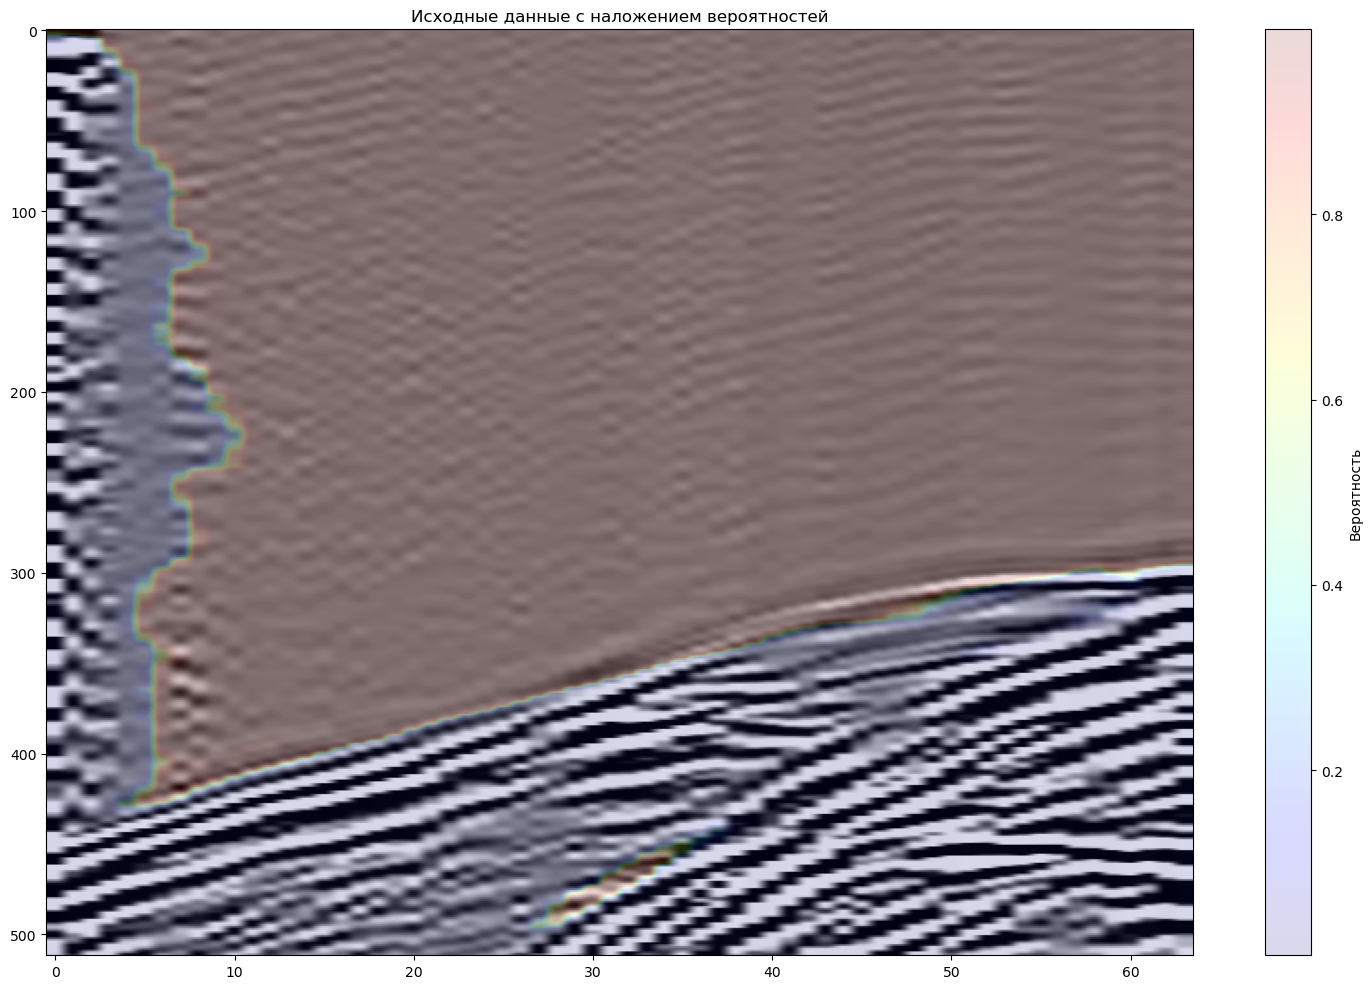

In [46]:


# Extract the probability and original data
i = 1
prob_data = prob1[i][0].detach().numpy().astype(np.float32)
original_data = shot[i]

# Создаем рисунок и оси
fig, ax = plt.subplots(figsize=(15, 10))

# Сначала отображаем исходные данные в оттенках серого
im1 = ax.imshow(original_data, cmap='gray', aspect='auto', origin='upper')

# Затем накладываем данные вероятностей с повышенной прозрачностью
im2 = ax.imshow(prob_data, cmap='jet', alpha=0.15, aspect='auto', origin='upper')  # Уменьшил alpha с 0.5 до 0.3

# Добавляем цветовую шкалу для наложения вероятностей
cbar = plt.colorbar(im2, ax=ax, label='Вероятность')

plt.title('Исходные данные с наложением вероятностей')
plt.tight_layout()
plt.show()

In [43]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def filter_small_clusters(red_probabilities, threshold=0.5):
    """Оставляет только самый большой кластер"""
    binary_mask = (red_probabilities > threshold).astype(np.uint8)
    if np.sum(binary_mask) == 0:
        return red_probabilities
    
    labeled_array, num_features = ndimage.label(binary_mask)
    if num_features <= 1:
        return red_probabilities
    
    sizes = np.bincount(labeled_array.flatten())
    largest_cluster = np.argmax(sizes[1:]) + 1
    largest_mask = (labeled_array == largest_cluster)
    
    filtered_probabilities = np.copy(red_probabilities)
    filtered_probabilities[binary_mask & (~largest_mask)] = 0.0
    
    return filtered_probabilities

def find_class_boundaries(probabilities, threshold=0.5):
    """Находит границу для каждой вертикали"""
    height, width = probabilities.shape
    boundaries = []
    
    for col in range(width):
        column_data = probabilities[:, col]
        binary_column = (column_data > threshold).astype(int)
        transitions = np.diff(binary_column)
        transition_indices = np.where(transitions != 0)[0]
        
        if len(transition_indices) == 0:
            boundaries.append(None)
        else:
            # Берем индекс последнего перехода
            boundaries.append(transition_indices[-1] + 1)
    
    return boundaries

def simple_merge_boundaries(prob1, shot, points, split_nt, threshold=0.5):
    """
    Простое объединение границ
    
    Параметры:
    - prob1: тензор вероятностей для подизображений
    - shot: список подизображений
    - points: стартовые позиции подизображений
    - split_nt: ширина подизображения
    - threshold: порог для бинаризации
    
    Возвращает:
    - объединенную границу для всего изображения
    """
    # Определяем полную ширину изображения
    total_width = points[-1] + split_nt
    
    # Создаем массив для сбора всех значений границ
    # Для каждой вертикали будем хранить список значений
    all_boundaries = [[] for _ in range(total_width)]
    
    # Обрабатываем каждое подизображение
    for i, start_point in enumerate(points):
        # Получаем вероятности для этого подизображения
        prob_data = prob1[i][0].detach().numpy().astype(np.float32)
        
        # Фильтруем малые кластеры
        filtered_prob = filter_small_clusters(prob_data, threshold)
        
        # Находим границу
        boundaries = find_class_boundaries(filtered_prob, threshold)
        
        # Добавляем значения границ в общий список
        for j, boundary in enumerate(boundaries):
            if boundary is not None:
                pos = start_point + j
                if pos < total_width:
                    all_boundaries[pos].append(boundary)
    
    # Выбираем итоговую границу как медиану значений в каждой вертикали
    merged_boundary = []
    for values in all_boundaries:
        if values:
            # Если есть значения, берем медиану
            merged_boundary.append(int(np.median(values)))
        else:
            # Если значений нет, ставим None
            merged_boundary.append(None)
    
    # Заполняем пропуски интерполяцией между соседними значениями
    for i in range(len(merged_boundary)):
        if merged_boundary[i] is None:
            # Находим ближайшие не-None значения слева и справа
            left_val, right_val = None, None
            left_idx, right_idx = i, i
            
            # Ищем слева
            while left_idx > 0:
                left_idx -= 1
                if merged_boundary[left_idx] is not None:
                    left_val = merged_boundary[left_idx]
                    break
            
            # Ищем справа
            while right_idx < len(merged_boundary) - 1:
                right_idx += 1
                if merged_boundary[right_idx] is not None:
                    right_val = merged_boundary[right_idx]
                    break
            
            # Заполняем значение интерполяцией
            if left_val is not None and right_val is not None:
                # Линейная интерполяция
                merged_boundary[i] = left_val + (right_val - left_val) * (i - left_idx) // (right_idx - left_idx)
            elif left_val is not None:
                merged_boundary[i] = left_val
            elif right_val is not None:
                merged_boundary[i] = right_val
            else:
                # Если нигде нет значений, ставим 0
                merged_boundary[i] = 0
    
    return merged_boundary

def visualize_simple_merged_boundary(shot, points, split_nt, merged_boundary):
    """Визуализирует объединенную границу на полном изображении"""
    # Реконструируем полное изображение
    total_width = points[-1] + split_nt
    height = shot[0].shape[0]
    full_image = np.zeros((height, total_width))
    
    for i, start_point in enumerate(points):
        end_point = min(start_point + split_nt, total_width)
        full_image[:, start_point:end_point] = shot[i][:, :end_point-start_point]
    
    # Создаем визуализацию
    plt.figure(figsize=(15, 10))
    plt.imshow(full_image, cmap='gray', aspect='auto', origin='upper')
    
    # Добавляем линию границы
    plt.plot(np.arange(total_width), merged_boundary, 'r-', linewidth=2, label='Граница')
    
    # Показываем границы подизображений
    for point in points:
        plt.axvline(x=point, color='b', linestyle='--', alpha=0.5)
    
    plt.legend()
    plt.title('Полное изображение с объединенной границей')
    plt.tight_layout()
    plt.show()

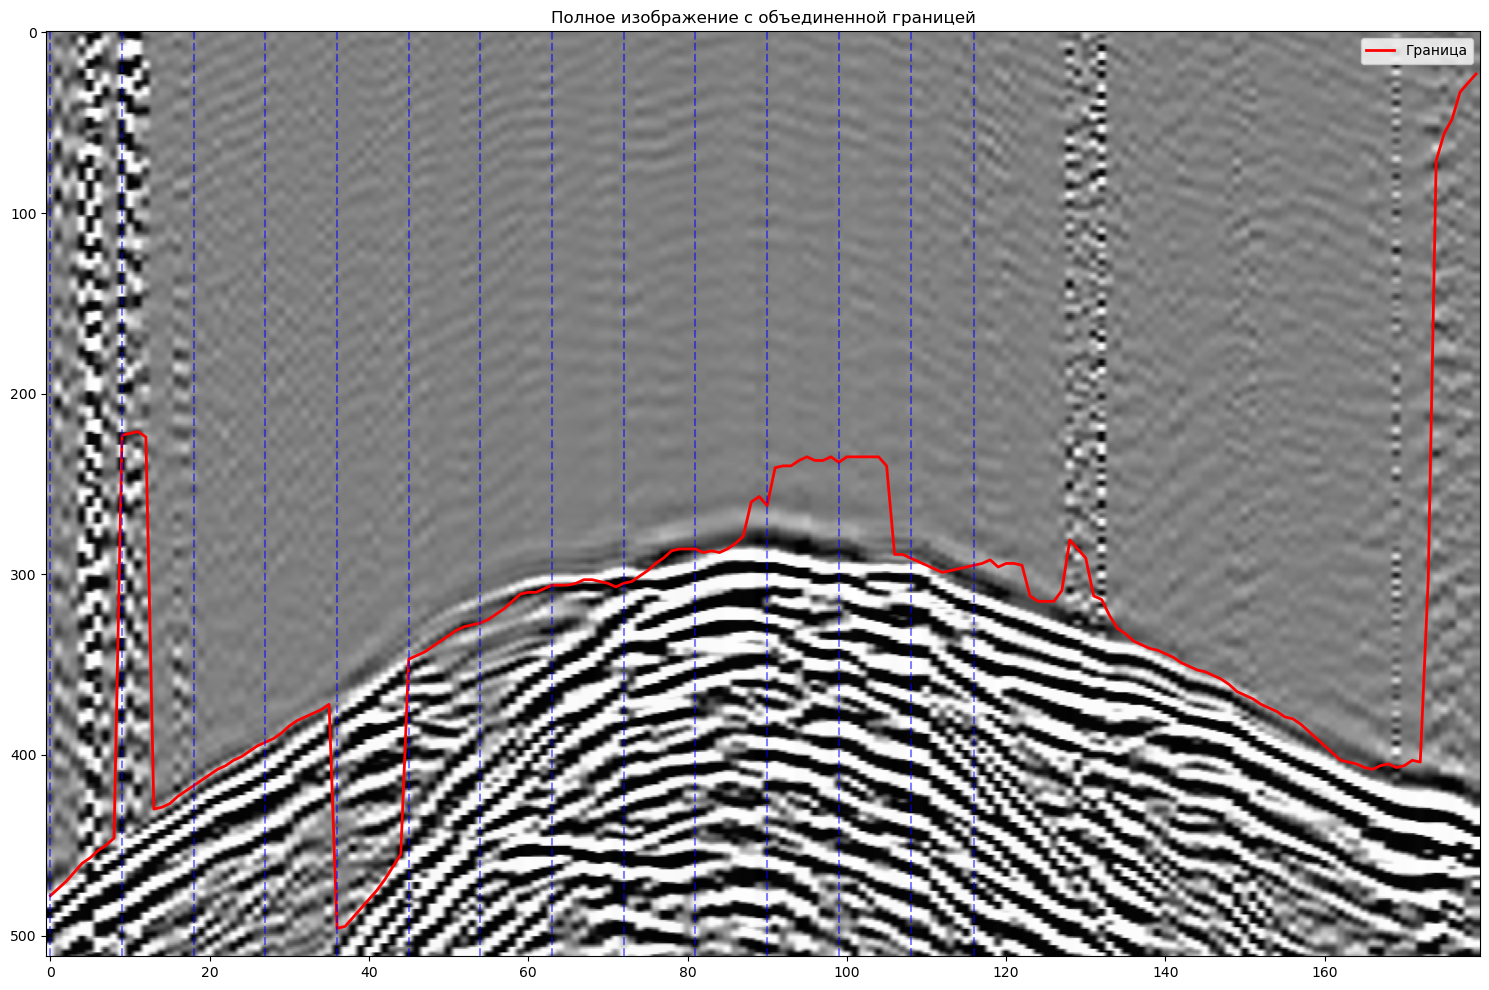

In [44]:
# После обработки изображений и получения predictions
merged_boundary = simple_merge_boundaries(
    prob1=prob1,
    shot=shot,
    points=points,
    split_nt=split_nt,
    threshold=0.5
)

# Визуализация результата
visualize_simple_merged_boundary(
    shot=shot,
    points=points,
    split_nt=split_nt,
    merged_boundary=merged_boundary
)

In [13]:
#file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/9744512.npy'
file_path = r'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/249452275193.npy'

shot = np.load(file_path)
time_window =[0, n_time_sampels]

shot = shot[time_window[0]:time_window[1], :]
shot = data_normalize_and_limiting(data=shot)
shot = shot_to_gray_scale(shot)

points = starting_points(shot.shape[1], split_nt, overlap)
sub_shots = shot_spliting(
    shot=shot,
    points=points,
    split_nt=split_nt
    )
len(sub_shots)

denom [4. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


/var/folders/qx/8lfz_yns1qv3pz4b786vy6dc0000gn/T/ipykernel_47091/1503819182.py:42: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)


14

In [31]:
data = shot
nom = data - np.mean(data, axis=0)
denom = 2 * (np.max(data, axis=0) - np.min(data, axis=0))
if denom.all() < 0.000001:
    print("denom", denom)
data = 255 * (nom/ denom + 0.5)
data[np.isnan(data)] = np.mean(data)


denom [255.   0.   0.   0.   0.   0.   0. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]


/var/folders/qx/8lfz_yns1qv3pz4b786vy6dc0000gn/T/ipykernel_47091/110918409.py:6: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)


In [32]:
data[:7]

array([[126.98766961,          nan,          nan, ..., 130.48412266,
        133.14699339, 126.0240903 ],
       [124.71604153,          nan,          nan, ..., 129.06762511,
        132.89413869, 125.20230726],
       [125.32547037,          nan,          nan, ..., 127.46808379,
        129.75599632, 125.56847093],
       ...,
       [135.21274248,          nan,          nan, ..., 124.45141009,
        119.74240337, 127.45951682],
       [137.39265811,          nan,          nan, ..., 123.06284054,
        117.80505488, 127.25296068],
       [132.68405191,          nan,          nan, ..., 122.01297467,
        119.71085564, 126.01017765]])

In [33]:
np.max(data, axis=0) - np.min(data, axis=0)

array([127.5,   nan,   nan,   nan,   nan,   nan,   nan, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5,
       127.5, 127.5,

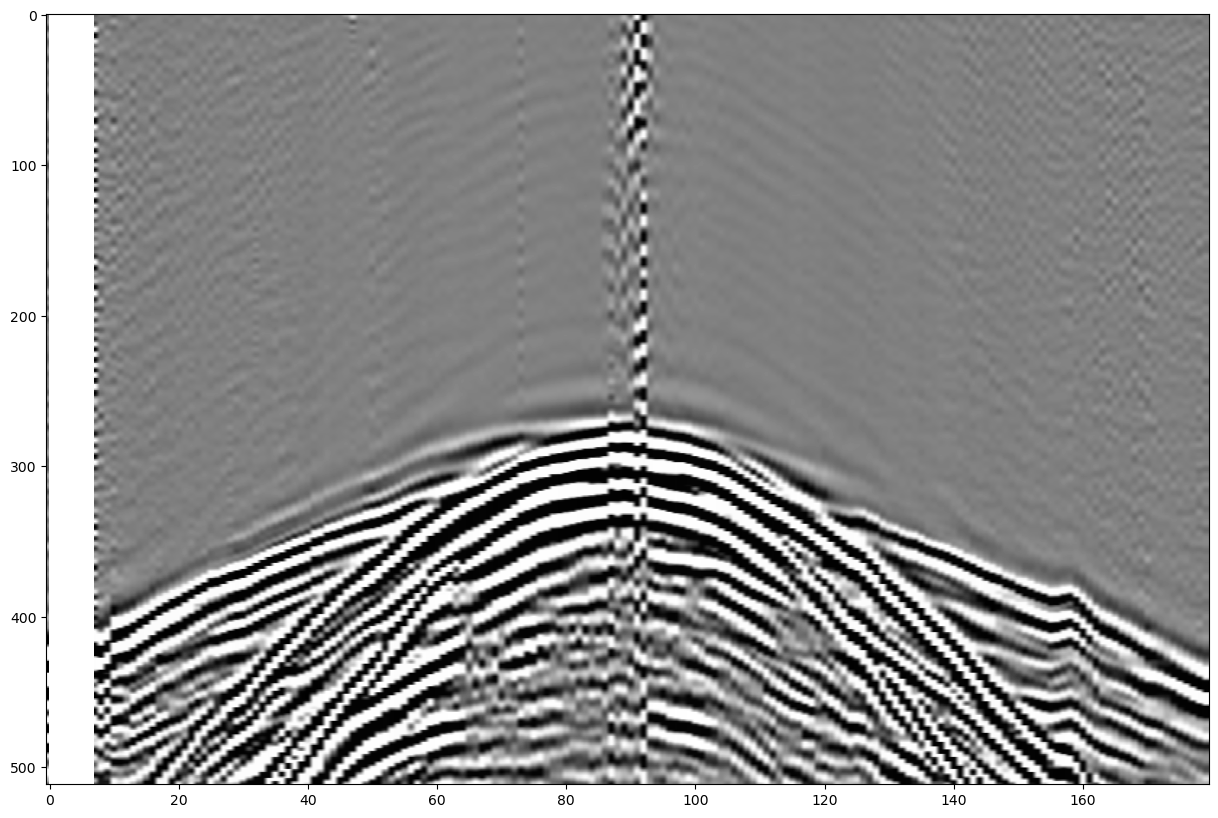

In [34]:
# ============== Часть 3: Отображение и переворот всей картинки ==============
fig, ax = plt.subplots(figsize=(15, 10))

# Отображаем изображение: транспонируем, чтобы ось X соответствовала трассам,
# и выбираем первые 125 трасс
im = ax.imshow(data, cmap='gray', aspect='auto')

In [4]:
%matplotlib inline
import numpy as np

In [ ]:
df = pd.read_csv('/Users/aleksei/jupyters/test_fbpicking_mokrous3d.txt', sep='\t', header = None)
df.columns = [x.strip() for x in "itrace  |   NSP |   NRP |   SLN |   RLN |   NTR |   FB_TIME".split("|")]
fb_time = df[(df.NSP == 64874)&(df.RLN == 4)].set_index('itrace').FB_TIME


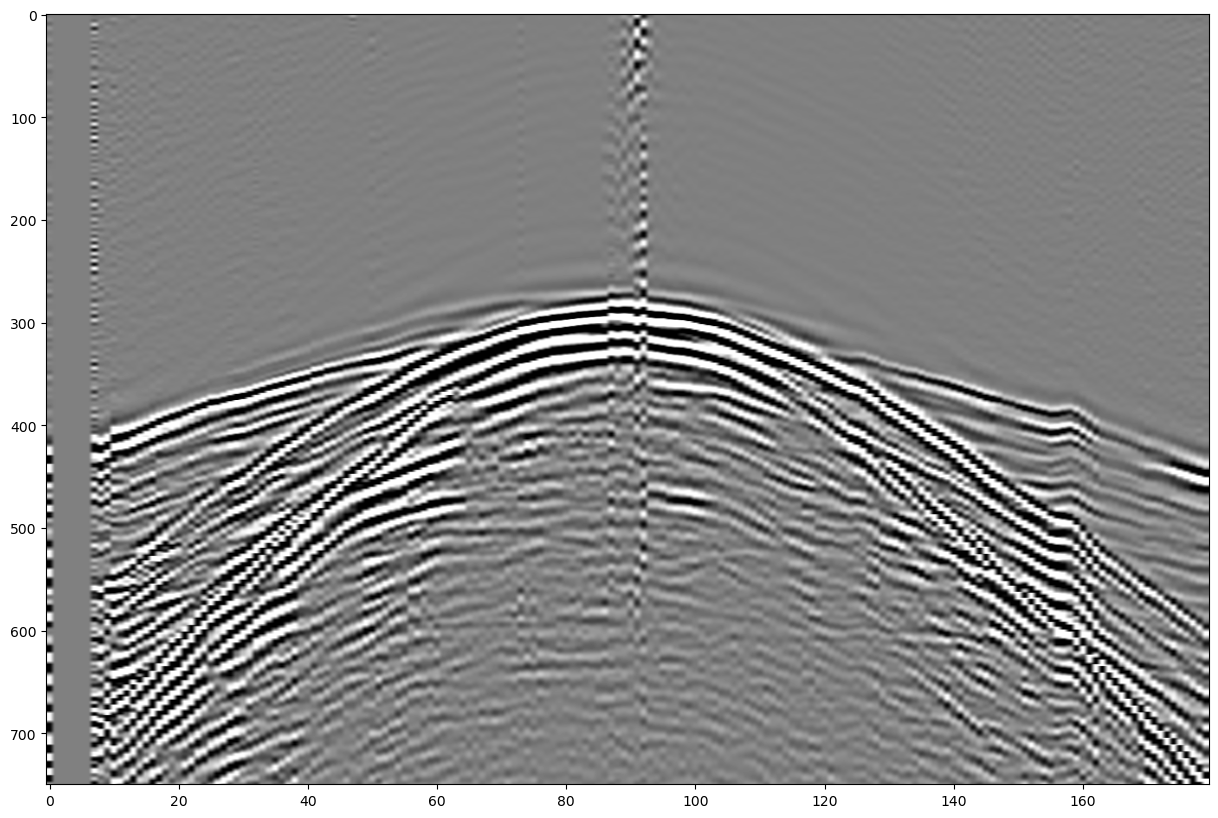

In [12]:
import matplotlib.pyplot as plt
data = np.load(r'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/249452275193.npy')
#data = np.load("first_break_picking/example/data/raw/dataset1/numpy_splited/seismogram_EnergySourcePoint_107541_GroupStaticCorrection_13.npy")
#time_picks = fb_time.reset_index(drop=True)/0.004

#data = data_normalize_and_limiting(data)

# ============== Часть 3: Отображение и переворот всей картинки ==============
fig, ax = plt.subplots(figsize=(15, 10))

# Отображаем изображение: транспонируем, чтобы ось X соответствовала трассам,
# и выбираем первые 125 трасс
im = ax.imshow(data, cmap='gray', aspect='auto')

#ax.plot(time_picks, color='red', linewidth=2,)


